In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.stats as stats
import sklearn.metrics as metrics
import spacetimekriging as stk
import floodprediction as fp
import dependence_modeling as dm
import mortgage_model as mm

In [2]:
### *** SET UP FOLDERS AND ENVIRONMENT *** ###

# Specify current working directory
pwd = os.getcwd()

# Specify output directory for figures and tables
outfolder = os.path.join(pwd,dt.datetime.today().strftime('%Y-%m-%d_figures_and_tables'))
if not os.path.exists(outfolder):
    os.makedirs(outfolder,exist_ok=True)

### *** GEOSPATIAL DATA SOURCES *** ###

# Specify CRS for maps
crs = 'EPSG:32617'

# Read in data on NC counties
counties_path = '/proj/characklab/flooddata/NC/multiple_events/geospatial_data/NC_counties'
counties = gpd.read_file(counties_path).to_crs(crs)
counties = counties[['FIPS','County','geometry']].rename(columns={'FIPS':'countyCode','County':'countyName'})

# Read in data on 2010 NC census tracts
census_tracts_path = f'/proj/characklab/flooddata/NC/multiple_events/geospatial_data/TIGER/nc_2010_census_tracts_clean'
census_tracts = gpd.read_file(census_tracts_path).to_crs(crs)
census_tracts = census_tracts.rename(columns={'GEOID':'censusTract_2010'})

# Matplotlib default settings
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

ERROR 1: PROJ: proj_create_from_database: Open of /proj/characklab/flooddata/NC/conda_environments/envs/flood_v1/share/proj failed


In [3]:
### *** DAMAGE MODEL PERFORMANCE & PROJECTIONS *** ###

print('*** DAMAGE MODEL ***',flush=True)

# Specify path to floodevent model runs
damage_dir = os.path.join(pwd,'2024-03-06_damage_estimates')

floodevent_filenames = np.sort(os.listdir(damage_dir))
floodevent_filepaths = [os.path.join(damage_dir,x) for x in floodevent_filenames]
floodevent_names = [x.split('_')[1] for x in floodevent_filenames]
floodevent_years = [pd.Timestamp(x.split('_')[0]).year for x in floodevent_filenames]
floodevent_labels = [f'{name}\n({year})' for name,year in zip(floodevent_names,floodevent_years)]
floodevent_list = []

for i,filepath in enumerate(floodevent_filepaths):
    
    print(floodevent_names[i],flush=True)
    
    with open(filepath, 'rb') as f:
        floodevent = pickle.load(f)
        
    floodevent_list.append(floodevent)

*** DAMAGE MODEL ***
Fran
Bonnie
Floyd
Isabel
Irene
Matthew
Florence


In [4]:
def get_performance(predictions_df):
    
    cost_response_variable = 'total_cost'
    presence_response_variable = 'flood_damage'

    y_pred = predictions_df[f'{presence_response_variable}_prob'].to_numpy()
    y_class = predictions_df[f'{presence_response_variable}_class'].to_numpy()
    y_true = predictions_df[presence_response_variable].to_numpy()
    c_pred = predictions_df[f'{cost_response_variable}_pred'].to_numpy()
    c_true = predictions_df[cost_response_variable].to_numpy()

    results_dict,roc_curve,pr_curve = fp.performance_metrics(y_pred,y_class,y_true,c_pred,c_true)
    
    # Get R^2 score among different groups
    m_TP = (y_true==1)&(y_class==1)
    m_TP_FP = (y_class==1)
    m_TP_FN = (y_true==1)
    
    if np.sum(m_TP) > 0:
        results_dict['Rsq_TP'] = metrics.r2_score(c_true[m_TP],c_pred[m_TP])
        results_dict['MAE_TP'] = metrics.mean_absolute_error(c_true[m_TP],c_pred[m_TP])
    else:
        results_dict['Rsq_TP'] = np.nan
        results_dict['MAE_TP'] = np.nan
    if np.sum(m_TP_FP) > 0:
        results_dict['Rsq_TP_FP'] = metrics.r2_score(c_true[m_TP_FP],c_pred[m_TP_FP])
        results_dict['MAE_TP_FP'] = metrics.mean_absolute_error(c_true[m_TP_FP],c_pred[m_TP_FP])
    else:
        results_dict['Rsq_TP_FP'] = np.nan
        results_dict['MAE_TP_FP'] = np.nan
        
    if np.sum(m_TP_FN) > 0:
        results_dict['Rsq_TP_FN'] = metrics.r2_score(c_true[m_TP_FN],c_pred[m_TP_FN])
        results_dict['MAE_TP_FN'] = metrics.mean_absolute_error(c_true[m_TP_FN],c_pred[m_TP_FN])
    else:
        results_dict['Rsq_TP_FN'] = np.nan
        results_dict['MAE_TP_FN'] = np.nan
    
    return(pd.DataFrame({'metric':results_dict.keys(),'value':results_dict.values()}))

def stratify_performance_by_sfha_pa(pa_predictions):
    
    nonpa_predictions = pa_predictions[~pa_predictions['pseudo_absence']]
    
    pa_sfha_predictions = pa_predictions[pa_predictions['SFHA']==1]
    pa_nonsfha_predictions = pa_predictions[pa_predictions['SFHA']==0]
    nonpa_sfha_predictions = nonpa_predictions[nonpa_predictions['SFHA']==1]
    nonpa_nonsfha_predictions = nonpa_predictions[nonpa_predictions['SFHA']==0]
    
    pa_overall_perf = get_performance(pa_predictions)
    pa_sfha_perf = get_performance(pa_sfha_predictions)
    pa_nonsfha_perf = get_performance(pa_nonsfha_predictions)
    
    nonpa_overall_perf = get_performance(nonpa_predictions)
    nonpa_sfha_perf = get_performance(nonpa_sfha_predictions)
    nonpa_nonsfha_perf = get_performance(nonpa_nonsfha_predictions)
    
    pa_overall_perf['pseudo_absence'] = 'included'
    pa_sfha_perf['pseudo_absence'] = 'included'
    pa_nonsfha_perf['pseudo_absence'] = 'included'
    
    nonpa_overall_perf['pseudo_absence'] = 'excluded'
    nonpa_sfha_perf['pseudo_absence'] = 'excluded'
    nonpa_nonsfha_perf['pseudo_absence'] = 'excluded'
    
    pa_overall_perf['SFHA'] = 'both'
    nonpa_overall_perf['SFHA'] = 'both'
    
    pa_sfha_perf['SFHA'] = 'inside'
    nonpa_sfha_perf['SFHA'] = 'inside'
    
    pa_nonsfha_perf['SFHA'] = 'outside'
    nonpa_nonsfha_perf['SFHA'] = 'outside'
    
    df = pd.concat([pa_overall_perf,pa_sfha_perf,pa_nonsfha_perf,nonpa_overall_perf,nonpa_sfha_perf,nonpa_nonsfha_perf]).reset_index(drop=True)
    
    return(df)

In [5]:
## Estimate model performance metrics across different stratifications:
## by event, including/excluding pseudo-absences, random/spatial cv, inside/outside SFHA


cv_perf_list = []

for i in range(len(floodevent_list)):

    random_cv_perf = stratify_performance_by_sfha_pa(floodevent_list[i].random_cv_predictions)
    spatial_cv_perf = stratify_performance_by_sfha_pa(floodevent_list[i].spatial_cv_predictions)

    random_cv_perf['cv_type'] = 'random'
    spatial_cv_perf['cv_type'] = 'spatial'

    event_perf = pd.concat([random_cv_perf,spatial_cv_perf])
    event_perf['event_year'] = floodevent_years[i]
    event_perf['event_name'] = floodevent_names[i]
    
    cv_perf_list.append(event_perf)

cv_perf = pd.concat(cv_perf_list).reset_index(drop=True)
cv_perf = cv_perf[['event_year','event_name','cv_type','pseudo_absence','SFHA','metric','value']]
cv_perf = pd.pivot(cv_perf,index=['event_year','event_name','cv_type','pseudo_absence','SFHA'],columns='metric',values='value')

outname = os.path.join(outfolder,'damage_prediction_cross_validation_performance.csv')
cv_perf.to_csv(outname)

/proj/characklab/flooddata/NC/conda_environments/envs/flood_v1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/proj/characklab/flooddata/NC/conda_environments/envs/flood_v1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/proj/characklab/flooddata/NC/conda_environments/envs/flood_v1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/proj/characklab/flooddata/NC/conda_environments/envs/flood_v1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

In [6]:
def metrics_barplot(perf_data,metrics,metric_labels,metric_min,metric_max,metric_increment,cv_type='random',pseudo_absence='included',figsize=(8,10)):
    
    fig,axes = plt.subplots(nrows=len(metrics),ncols=1,figsize=figsize)

    major_spacing = 4
    minor_spacing = 1

    for i in range(len(metrics)):

        metric = metrics[i]
        metric_label = metric_labels[i]
        min_val = metric_min[i]
        max_val = metric_max[i]
        increment = metric_increment[i]

        ax = axes[i]

        y_overall = perf_data.loc[:,:,cv_type,pseudo_absence,'both'][metric]
        y_sfha = perf_data.loc[:,:,cv_type,pseudo_absence,'inside'][metric]
        y_nonsfha = perf_data.loc[:,:,cv_type,pseudo_absence,'outside'][metric]

        event_labels = [f'{x[1]}\n({x[0]})' for x in y_overall.index.values]
        n_events = len(event_labels)

        x_pos_sfha = np.arange(0,major_spacing*n_events,major_spacing)
        x_pos_overall = x_pos_sfha - minor_spacing
        x_pos_nonsfha = x_pos_sfha + minor_spacing

        alpha=1

        ax.bar(x_pos_overall,y_overall,width=minor_spacing,color='#004056',label='Overall',lw=1.5,edgecolor='k',alpha=alpha)
        ax.bar(x_pos_sfha,y_sfha,width=minor_spacing,color='#2C858D',label='SFHA',lw=1.5,edgecolor='k',alpha=alpha)
        ax.bar(x_pos_nonsfha,y_nonsfha,width=minor_spacing,color='#74CEB7',label='non-SFHA',lw=1.5,edgecolor='k',alpha=alpha)

        ax.set_xticks(x_pos_sfha)
        ax.set_xticklabels(event_labels)

        ax.set_yticks(np.arange(min_val,max_val+0.0001,increment))
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray')

        ax.set_ylim([min_val,max_val])
        ax.legend(loc='upper left')

        ax.set_ylabel(metric_label,fontsize=12)

    fig.tight_layout()
    
    return(fig,axes)

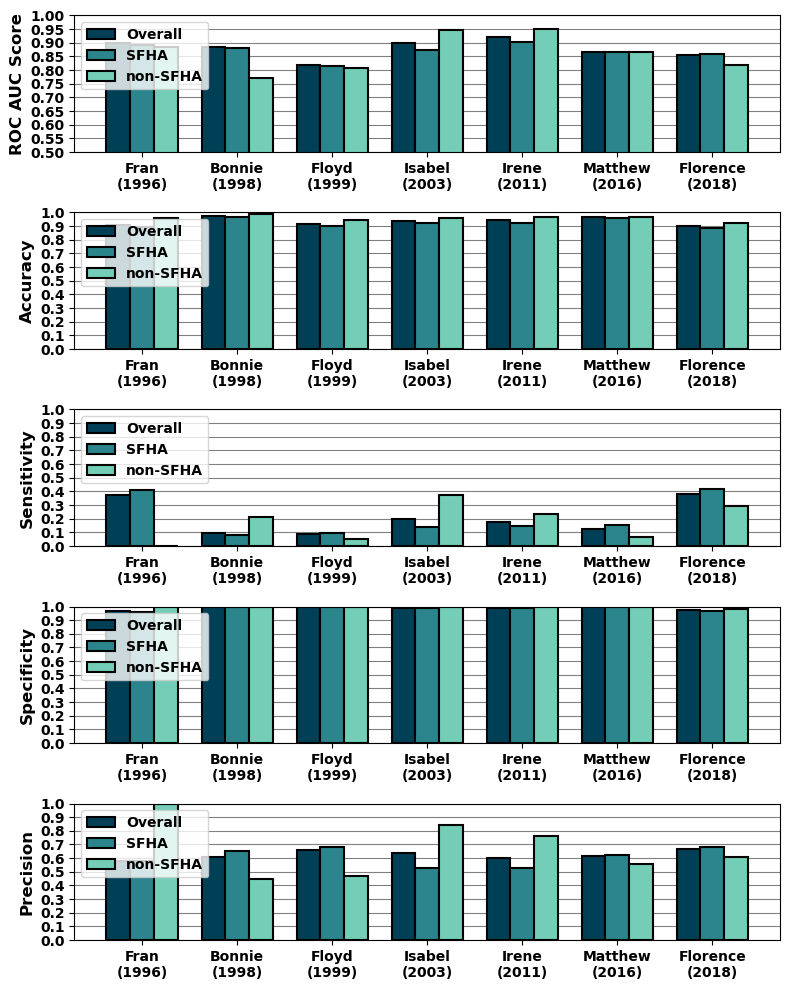

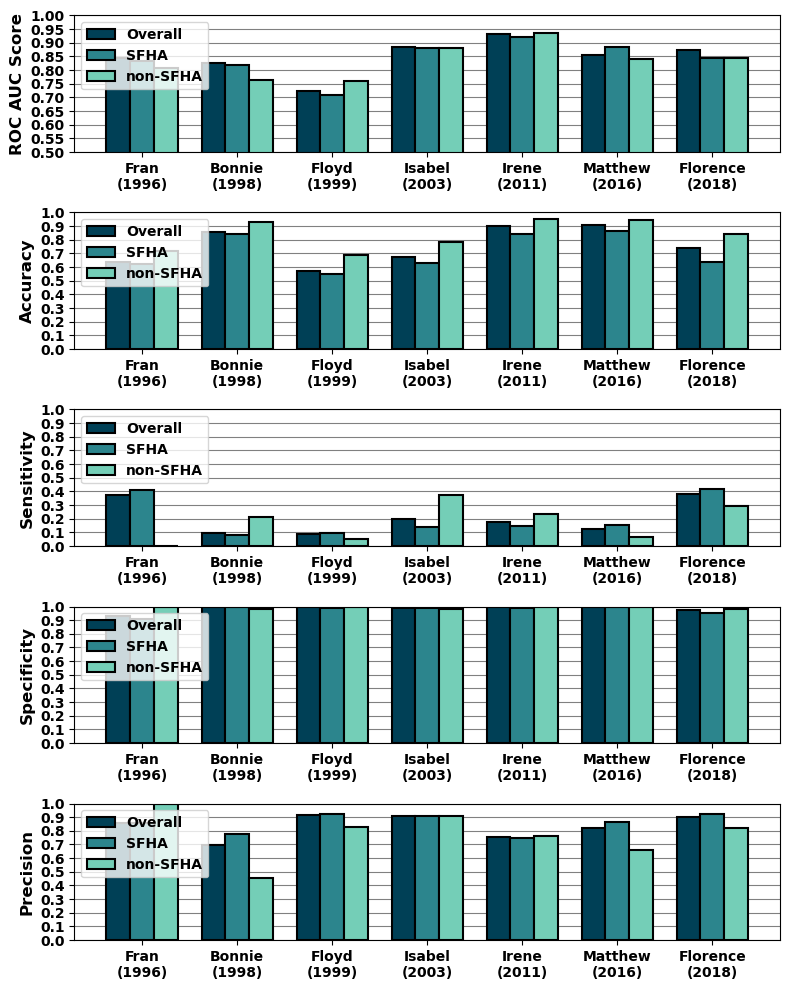

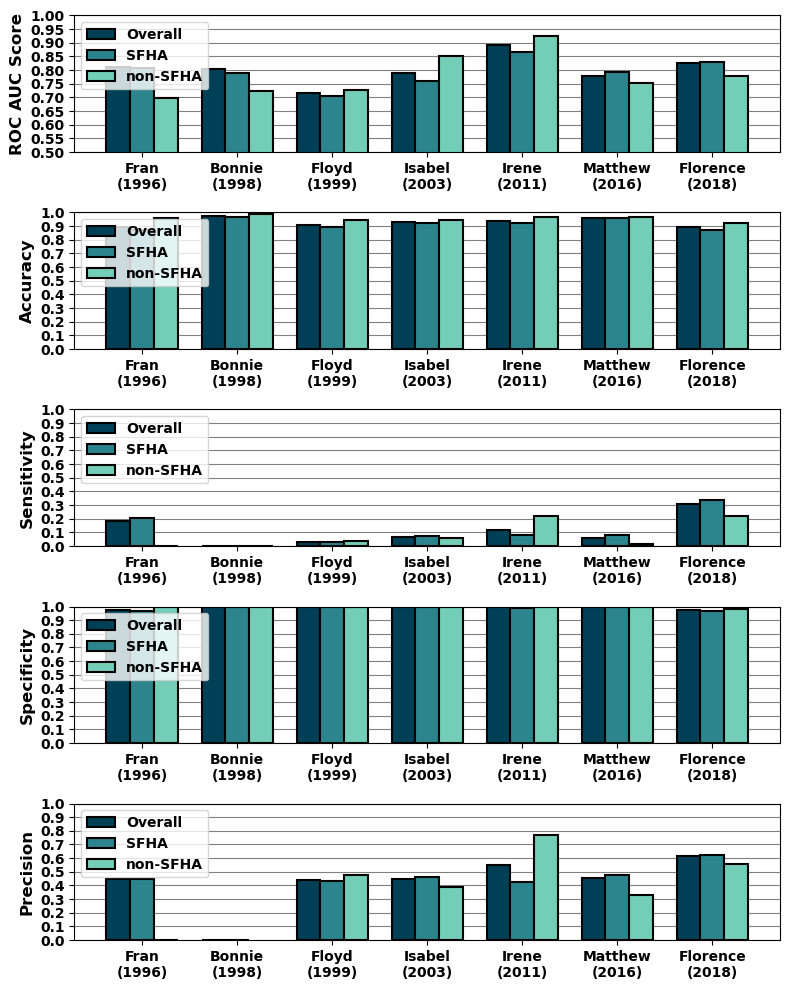

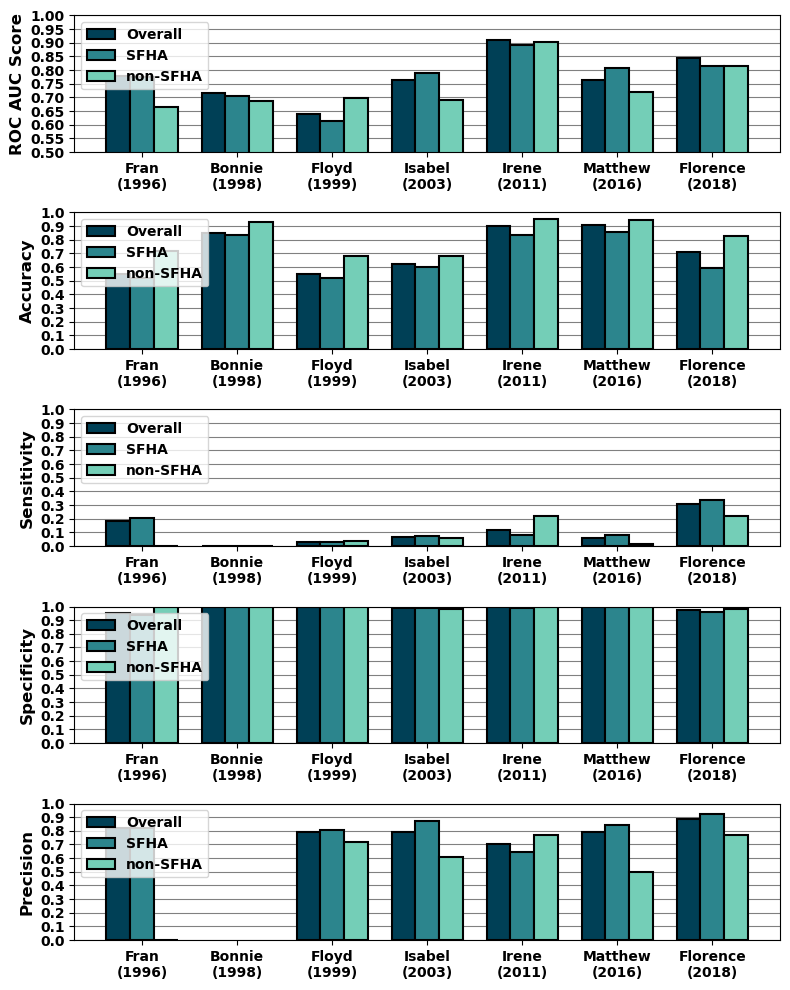

In [7]:
# Create barplots of presence-absence model performance

metrics = ['roc_auc','accuracy','sensitivity','specificity','precision']
metric_labels = ['ROC AUC Score','Accuracy','Sensitivity','Specificity','Precision']
metric_min = [0.5,0.0,0.0,0.0,0.0]
metric_max = [1.0,1.0,1.0,1.0,1.0]
metric_increment = [0.05,0.1,0.1,0.1,0.1]

## Random CV

# Including pseudo-absences
fig,axes=metrics_barplot(cv_perf,metrics,metric_labels,metric_min,metric_max,metric_increment,cv_type='random',pseudo_absence='included')
fig.tight_layout()
outname = os.path.join(outfolder,'random_cv_performance_including_pseudo_absences.png')
fig.savefig(outname,dpi=400)

fig,axes=metrics_barplot(cv_perf,metrics,metric_labels,metric_min,metric_max,metric_increment,cv_type='random',pseudo_absence='excluded')
fig.tight_layout()
outname = os.path.join(outfolder,'random_cv_performance_excluding_pseudo_absences.png')
fig.savefig(outname,dpi=400)

fig,axes=metrics_barplot(cv_perf,metrics,metric_labels,metric_min,metric_max,metric_increment,cv_type='spatial',pseudo_absence='included')
fig.tight_layout()
outname = os.path.join(outfolder,'spatial_cv_performance_including_pseudo_absences.png')
fig.savefig(outname,dpi=400)

fig,axes=metrics_barplot(cv_perf,metrics,metric_labels,metric_min,metric_max,metric_increment,cv_type='spatial',pseudo_absence='excluded')
fig.tight_layout()
outname = os.path.join(outfolder,'spatial_cv_performance_excluding_pseudo_absences.png')
fig.savefig(outname,dpi=400)

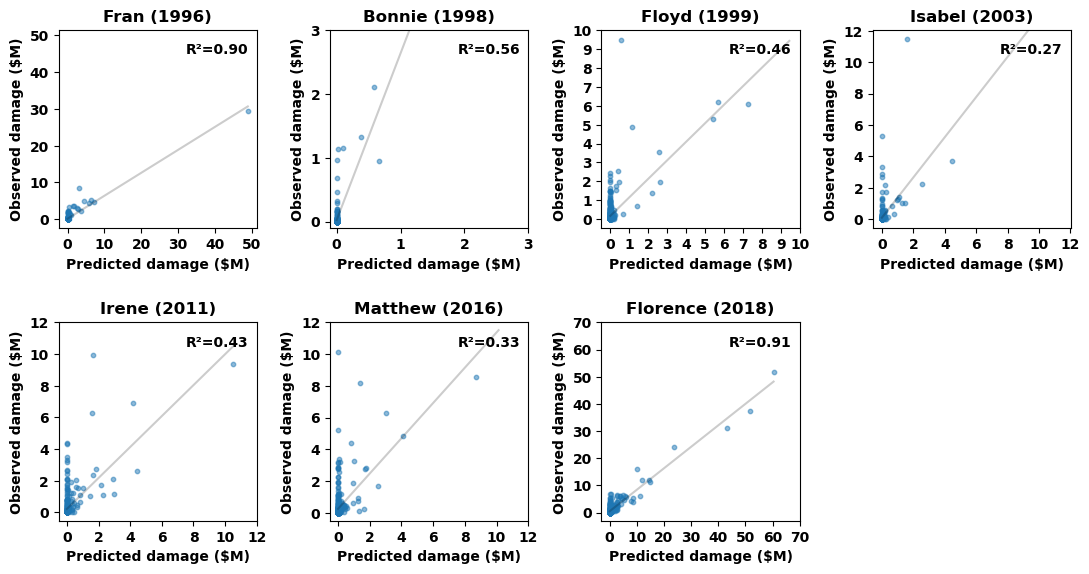

In [8]:
## Calcualte R^2 values associated with damage cost prediction by event
## Aggregate cross-validation predicted damages by some geographic unit

n_events = len(floodevent_list)

fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(11,6))

for i in range(n_events):
    
    ai = i // 4
    aj = i - 4*ai
    
    ax = axes[ai,aj]
    
    predictions = floodevent_list[i].random_cv_predictions
    
    geographic_units = floodevent_list[i].spatial_cv_tiles.rename(columns={'fold':'tile'})
    geographic_column = 'tile'

    predictions = gpd.sjoin_nearest(predictions,geographic_units,max_distance=1000).drop(columns=['index_right'])
    df = predictions[['total_cost','total_cost_pred',geographic_column]].groupby(geographic_column).sum().reset_index()

    x = df['total_cost_pred'].to_numpy()/1e6
    y = df['total_cost'].to_numpy()/1e6
    
    maxval = np.max(np.concatenate((x,y)))
    
    xline = np.linspace(0,maxval,101)
        
    if maxval > 40:
        increment = 10
    elif maxval > 20:
        increment = 5
    elif maxval > 10:
        increment = 2
    else:
        increment = 1
    
    ticks = np.arange(0,maxval+increment,increment)
    
    minval = -0.05*maxval
    maxval = 1.05*maxval

    res = stats.linregress(x, y)

    slope = res.slope
    intercept = res.intercept
    rsq = res.rvalue**2
    rsq = np.round(rsq,2)
    
    yline = slope*xline+intercept

    ax.scatter(x,y,alpha=0.5,s=10)
    ax.plot(xline,yline,'k-',alpha=0.2)

    ax.set_ylim([minval,maxval])
    ax.set_xlim([minval,maxval])
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    ax.set_xlabel('Predicted damage ($M)')
    ax.set_ylabel('Observed damage ($M)')
    
    ax.text(0.8, 0.9, f'R²={rsq:.2f}',
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes)
    
    title = f'{floodevent_names[i]} ({floodevent_years[i]})'
    ax.set_title(title,fontweight='bold')
    ax.set_aspect('equal')
    
axes[-1,-1].axis('off')

fig.tight_layout()

outname = os.path.join(outfolder,'random_cv_damage_cost_error.png')
fig.savefig(outname,dpi=400)

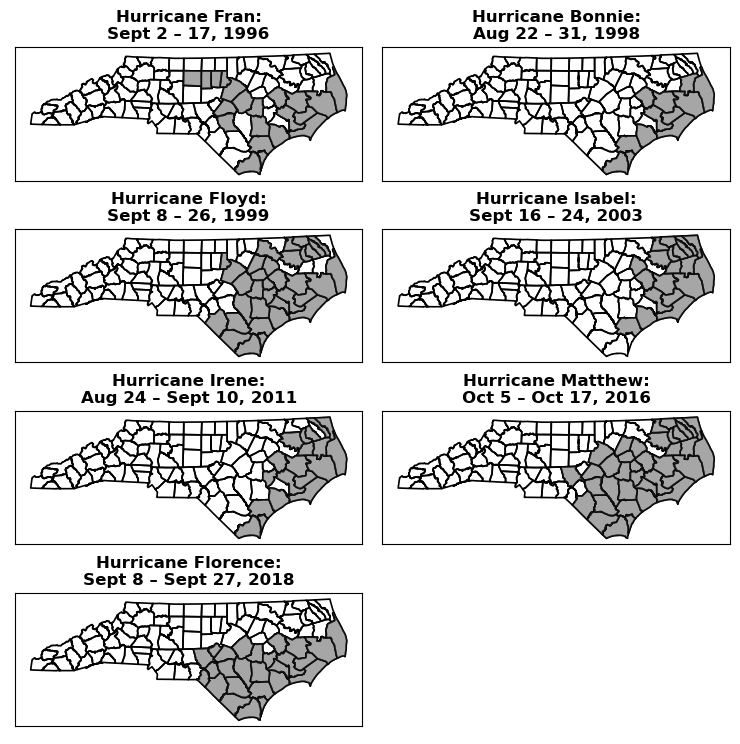

In [9]:
## Create included counties maps

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(7.5,7.5))

labels=['Hurricane Fran:\nSept 2 – 17, 1996',
        'Hurricane Bonnie:\nAug 22 – 31, 1998',
        'Hurricane Floyd:\nSept 8 – 26, 1999',
        'Hurricane Isabel:\nSept 16 – 24, 2003',
        'Hurricane Irene:\nAug 24 – Sept 10, 2011',
        'Hurricane Matthew:\nOct 5 – Oct 17, 2016',
        'Hurricane Florence:\nSept 8 – Sept 27, 2018']

for i in range(7):
    
    label = labels[i]
    
    ai = i // 2
    aj = i - 2*ai
    
    ax = axes[ai,aj]
    
    study_area = floodevent_list[i].study_area
    included_counties = counties[counties['geometry'].centroid.intersects(study_area)]

    counties.plot(ax=ax,facecolor='none',edgecolor='k',alpha=1,lw=1.2)
    included_counties.plot(ax=ax,facecolor='grey',edgecolor='k',alpha=0.7,lw=1.2)
    
    ax.set_title(label,fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[-1,-1].axis('off')

fig.tight_layout()

outname = os.path.join(outfolder,'event_boundaries.png')
fig.savefig(outname,dpi=400)

fig.show()

In [10]:
# Create table with counts of included claims, pseudo-absences, etc. by event

n_claims_list = []
n_address_policies_list = []
n_auxiliary_policies_list = []
n_presence_list = []
n_absence_list = []
n_pseudo_absence_list = []

for i in range(7):
    
    floodevent = floodevent_list[i]

    n_claims = len(floodevent.claims)
    n_address_policies = len(floodevent.policies)
    n_auxiliary_policies = len(floodevent.auxiliary_policies)

    n_presence = np.sum(floodevent.training_dataset['flood_damage']==1)
    n_absence = np.sum(floodevent.training_dataset['flood_damage']==0)
    n_pseudo_absence = floodevent.adjusted_training_dataset['pseudo_absence'].sum()
    
    n_claims_list.append(n_claims)
    n_address_policies_list.append(n_address_policies)
    n_auxiliary_policies_list.append(n_auxiliary_policies)
    n_presence_list.append(n_presence)
    n_absence_list.append(n_absence)
    n_pseudo_absence_list.append(n_pseudo_absence)
    
record_counts = pd.DataFrame(data={'event':floodevent_names,
                                   'n_claims':n_claims_list,
                                   'n_address_policies':n_address_policies_list,
                                   'n_auxiliary_policies':n_auxiliary_policies_list,
                                   'n_presence':n_presence_list,
                                   'n_absence':n_absence_list,
                                   'n_pseudo_absence':n_pseudo_absence_list})

outname = os.path.join(outfolder,'record_counts.csv')
record_counts.to_csv(outname,index=False)

# Compare claim totals to OpenFEMA records
n_total_claims = record_counts['n_claims'].sum()
n_total_policies = record_counts['n_address_policies'].sum()

openfema_claims_path = '/proj/characklab/flooddata/NC/multiple_events/geospatial_data/OpenFEMA/NC_FemaNfipClaims_v2.csv'
openfema_claims = pd.read_csv(openfema_claims_path)
openfema_claims['yearOfLoss'] = pd.to_datetime(openfema_claims['dateOfLoss']).dt.year
m = (openfema_claims['yearOfLoss'] >= 1996)&(openfema_claims['yearOfLoss'] <= 2019)
openfema_claims = openfema_claims[m]
openfema_claims['DamageAmount'] = openfema_claims['buildingDamageAmount'].fillna(0) + openfema_claims['contentsDamageAmount'].fillna(0)
openfema_claims = openfema_claims[openfema_claims['DamageAmount'] > 0]

n_openfema_claims = len(openfema_claims)

print('Number of included claims:',n_total_claims,flush=True)
print('Number of included policies:',n_total_policies,flush=True)
print('Number of OpenFEMA claims in NC, 1996-2019:',n_openfema_claims,flush=True)

Number of included claims: 39702
Number of included policies: 142092
Number of OpenFEMA claims in NC, 1996-2019: 75542


/tmp/ipykernel_2050668/974196342.py:45: DtypeWarning: Columns (7,35,42,52,61) have mixed types. Specify dtype option on import or set low_memory=False.
  openfema_claims = pd.read_csv(openfema_claims_path)


In [11]:
## Property value estimation cross-validation error
property_value_dir = '/proj/characklab/flooddata/NC/multiple_events/analysis/property_value_estimates_by_county'
complete_counties = [x.name for x in os.scandir(property_value_dir) if x.is_dir() and not x.name.startswith('.')]
complete_counties = np.sort(complete_counties)

cv_list = []

for county in complete_counties:
        
    cv_filepath = os.path.join(property_value_dir,f'{county}/{county}_cross_validation.parquet')
    
    # Read in cross-validation data
    table = pq.read_table(cv_filepath,use_pandas_metadata=True)
    cv_list.append(table.to_pandas())
    
cv_df = pd.concat(cv_list).reset_index(drop=True)
cv_df['year'] = cv_df['date_transfer'].dt.year

All:
67.0 within $50k
85.0 within $100k
Under $300k:
72.0 within $50k
90.0 within $100k


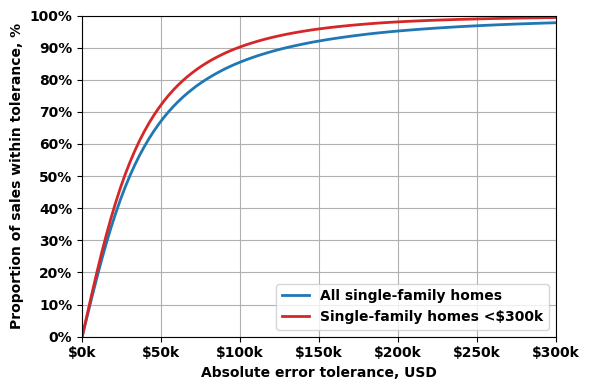

In [12]:
# Get distirbution of absolute error
d1 = dm.empirical_distribution(cv_df['abs_error_nonlog'].to_numpy(),estimate_pdf=False)
d2 = dm.empirical_distribution(cv_df[cv_df['val_transfer']<300000]['abs_error_nonlog'].to_numpy(),estimate_pdf=False)

x = np.linspace(0,300000+1,100)
y1 = d1.cdf(x)*100
y2 = d2.cdf(x)*100

fig,ax = plt.subplots(figsize=(6,4))

xticks = np.arange(0,300000+1,50000)
xticklabels = [f'${int(x/1000)}k' for x in xticks]

yticks = np.arange(0,100+1,10)
yticklabels = [f'{int(y)}%' for y in yticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Absolute error tolerance, USD')
ax.set_ylabel('Proportion of sales within tolerance, %')

ax.plot(x,y1,lw=2,color='C0',label='All single-family homes')
ax.plot(x,y2,lw=2,color='C3',label='Single-family homes <$300k')

ax.grid('on')

ax.set_xlim([0,300000])
ax.set_ylim([0,100])

ax.legend()

fig.tight_layout()

outname = os.path.join(outfolder,'pv_abs_error_cdf.png')
fig.savefig(outname,dpi=400)

fig.show()

print('All:')
print(np.round(100*d1.cdf(50000)),'within $50k')
print(np.round(100*d1.cdf(100000)),'within $100k')

print('Under $300k:')
print(np.round(100*d2.cdf(50000)),'within $50k')
print(np.round(100*d2.cdf(100000)),'within $100k')

In [13]:
## Look at trends in prediction error temporally and spatially
years = np.arange(1990,2019+1)

error_by_year = []

for year in years:
    error_by_year.append(cv_df[cv_df['year']==year]['abs_error_nonlog'].to_numpy())
    
error_by_county = cv_df[['countyCode','abs_error_nonlog']].groupby('countyCode').median().reset_index()
error_by_county = pd.merge(counties,error_by_county,on='countyCode',how='left')

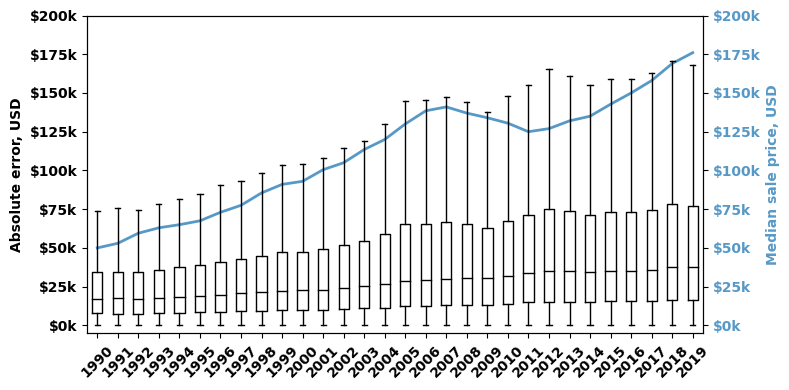

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))

ax.boxplot(error_by_year,sym='',medianprops={'color':'k'})
ax.set_xticklabels(years,rotation=45)

ymax = 200000
yticks = np.arange(0,ymax+1,25000)
yticklabels = [f'${int(y/1000)}k' for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylim(-5000,ymax)

ax2 = ax.twinx()
ax2.set_yticks(yticks)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels,color='C0',alpha=0.75)
ax2.set_ylim(-5000,ymax)

ax2.set_ylabel('Median sale price, USD',color='C0',alpha=0.75)

ax.set_ylabel('Absolute error, USD')

xpos = np.arange(len(years))+1
median_sale_price = cv_df[['val_transfer','year']].groupby('year').median()['val_transfer'].to_numpy()

ax.plot(xpos,median_sale_price,color='C0',lw=2,linestyle='-',alpha=0.75,zorder=-2)

fig.tight_layout()

outname = os.path.join(outfolder,'pv_abs_error_by_year.png')
fig.savefig(outname,dpi=400)

fig.show()

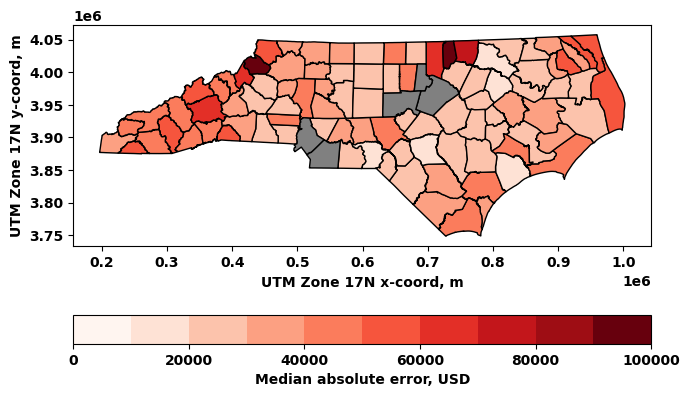

In [15]:
fig,ax = plt.subplots(figsize=(7,5))

missing_kwds={'edgecolor':'k','facecolor':'grey'}
legend_kwds = {'label':'Median absolute error, USD','orientation':'horizontal'}

cmap = plt.get_cmap('Reds', 10)
error_by_county.plot(ax=ax,column='abs_error_nonlog',cmap=cmap,vmin=0,vmax=100000,edgecolor='k',missing_kwds=missing_kwds,legend=True,legend_kwds=legend_kwds)

ax.set_xlabel('UTM Zone 17N x-coord, m')
ax.set_ylabel('UTM Zone 17N y-coord, m')

fig.tight_layout()

outname = os.path.join(outfolder,'pv_abs_error_by_county.png')
fig.savefig(outname,dpi=400)

fig.show()

In [16]:
# Display top 5 worst-performing counties
print(error_by_county.sort_values(by='abs_error_nonlog',ascending=False).iloc[:5][['countyName','abs_error_nonlog']],flush=True)

# Display number of counties with median abs error <$50,000

print('\nMedian error <$50k in',np.sum(error_by_county['abs_error_nonlog'] < 50000),'/ 100 counties.',flush=True)

   countyName  abs_error_nonlog
89      Vance     104292.789764
88    Watauga     100356.839827
91     Warren      79128.299308
79      Avery      68061.336040
83  Granville      60305.058430

Median error <$50k in 80 / 100 counties.


In [17]:
## Read in data from borrower simulation model

mortgage_sim_dir = '/proj/characklab/flooddata/NC/multiple_events/analysis/mortgage_borrower_simulation_postprocessed'

sim_filepath = os.path.join(mortgage_sim_dir,'simulation_output.parquet')
damaged_sim_filepath = os.path.join(mortgage_sim_dir,'simulation_output_damaged.parquet')

sim_usecols=['loan_id','loan_purpose','loan_term','loan_age','termination_code']
sim_df = pq.read_table(sim_filepath,columns=sim_usecols,use_pandas_metadata=True).to_pandas()
damaged_sim_df = pq.read_table(damaged_sim_filepath,use_pandas_metadata=True).to_pandas()

# Get observations from month in which damage occurs
damaged_sim_df = damaged_sim_df[damaged_sim_df['insured_damage'] + damaged_sim_df['uninsured_damage'] > 0]

In [18]:
# Create income categories
income_quantiles = pd.read_csv(os.path.join(mortgage_sim_dir,'income_quantiles.csv'))
income_quantiles['period'] = pd.to_datetime(income_quantiles['period']).dt.to_period('M')
income_quantiles = income_quantiles.set_index('period')
income_quantiles['P0'] = 0.0
income_quantiles['P100'] = np.inf
income_quantiles = income_quantiles[['P0','P20','P40','P60','P80','P100']]

income_binning_function = lambda x: np.digitize(x['monthly_income'],bins=income_quantiles.loc[x['period']].values)

damaged_sim_df['income_group'] = damaged_sim_df.apply(income_binning_function,axis=1)
damaged_sim_df['income_group'].value_counts(normalize=True)

income_group
5    0.229281
4    0.209291
2    0.191405
3    0.188775
1    0.181248
Name: proportion, dtype: float64

In [19]:
# Create property value categories
pv_quantiles = pd.read_csv(os.path.join(mortgage_sim_dir,'property_value_quantiles.csv'))
pv_quantiles['period'] = pd.to_datetime(pv_quantiles['period']).dt.to_period('M')
pv_quantiles = pv_quantiles.set_index('period')
pv_quantiles['P0'] = 0.0
pv_quantiles['P100'] = np.inf
pv_quantiles = pv_quantiles[['P0','P20','P40','P60','P80','P100']]

pv_binning_function = lambda x: np.digitize(x['property_value'],bins=pv_quantiles.loc[x['period']].values)

damaged_sim_df['property_value_group'] = damaged_sim_df.apply(pv_binning_function,axis=1)
damaged_sim_df['property_value_group'].value_counts(normalize=True)

property_value_group
5    0.241138
1    0.228796
2    0.193064
4    0.170889
3    0.166114
Name: proportion, dtype: float64

In [20]:
# Get follow-up time for each loan
sim_futime = sim_df.groupby('loan_id').last().reset_index()

# Denote whether loan is paid back within simulation time horizon
sim_futime['event'] = (~sim_futime['termination_code'].isna()).astype(int)

p30_sim_futime = sim_futime[(sim_futime['loan_purpose']=='purchase')&(sim_futime['loan_term']==360)]
r30_sim_futime = sim_futime[(sim_futime['loan_purpose']=='refinance')&(sim_futime['loan_term']==360)]
r15_sim_futime = sim_futime[(sim_futime['loan_purpose']=='refinance')&(sim_futime['loan_term']==180)]

/tmp/ipykernel_2050668/2083816964.py:17: RuntimeWarning: invalid value encountered in scalar divide
  prob_event[i] = dt/nt


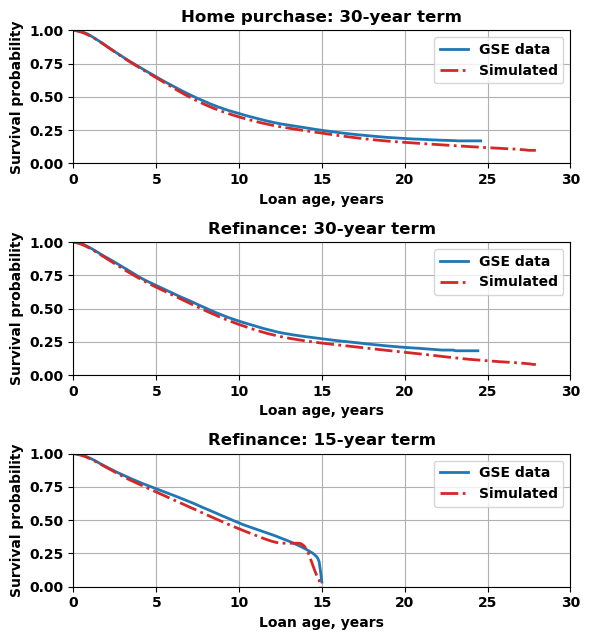

In [21]:
def kaplan_meier(time,event,t_max=360):
    """
    param: time: numpy array of failure / censoring times
    param: event: numpy array denoting whether the event occured (1) or didn't occur (0)
    param: t_max: maximum follow-up time to calculate survival for
    returns: S: kaplan-meier estimate of survival function at time t
    returns: tvals: timepoints of survival curve
    """
    
    tvals = np.arange(0,t_max+1)
    prob_event = np.zeros(len(tvals))

    for i,t in enumerate(tvals):
        nt = np.sum((time >= t))
        dt = np.sum(event[time == t])

        prob_event[i] = dt/nt

    S = np.cumprod(1-prob_event)
    S = S/S[0]
    
    return(S,tvals)

p30_km_sim,t = kaplan_meier(p30_sim_futime['loan_age'].to_numpy(),p30_sim_futime['event'].to_numpy())
r30_km_sim,t = kaplan_meier(r30_sim_futime['loan_age'].to_numpy(),r30_sim_futime['event'].to_numpy())
r15_km_sim,t = kaplan_meier(r15_sim_futime['loan_age'].to_numpy(),r15_sim_futime['event'].to_numpy())

# Read in data corresponding to GSE loans so we can compare simulated against actual
surv_dir = os.path.join(pwd,'2024-03-31_loan_survival_analysis')

p30_km_gse = pd.read_csv(os.path.join(surv_dir,'purchase30_km_estimate.csv'))
r30_km_gse = pd.read_csv(os.path.join(surv_dir,'refinance30_km_estimate.csv'))
r15_km_gse = pd.read_csv(os.path.join(surv_dir,'refinance15_km_estimate.csv'))

r15_km_gse = r15_km_gse[r15_km_gse['time'] <= 180]


ft=12
yticks = np.arange(0,1+0.01,0.25)
xticks = np.arange(0,30+1,5)

fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(6,6.5))

ax = axes[0]

ax.plot(p30_km_gse['time']/12,p30_km_gse['surv'],color='C0',lw=2,label='GSE data')
ax.plot(t/12,p30_km_sim,color='C3',lw=2,label='Simulated',ls='-.')
ax.set_xlim([0,30])
ax.set_ylim([0,1])
ax.set_title('Home purchase: 30-year term',fontsize=ft,weight='bold')
ax.set_xlabel('Loan age, years')
ax.set_ylabel('Survival probability')
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.legend()
ax.grid('on')

ax = axes[1]

ax.plot(r30_km_gse['time']/12,r30_km_gse['surv'],color='C0',lw=2,label='GSE data')
ax.plot(t/12,r30_km_sim,color='C3',lw=2,label='Simulated',ls='-.')
ax.set_xlim([0,30])
ax.set_ylim([0,1])
ax.set_title('Refinance: 30-year term',fontsize=ft,weight='bold')
ax.set_xlabel('Loan age, years')
ax.set_ylabel('Survival probability')
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.legend()
ax.grid('on')

ax = axes[2]

ax.plot(r15_km_gse['time']/12,r15_km_gse['surv'],color='C0',lw=2,label='GSE data')
ax.plot(t/12,r15_km_sim,color='C3',lw=2,label='Simulated',ls='-.')
ax.set_xlim([0,30])
ax.set_ylim([0,1])
ax.set_title('Refinance: 15-year term',fontsize=ft,weight='bold')
ax.set_xlabel('Loan age, years')
ax.set_ylabel('Survival probability')
ax.set_yticks(yticks)
ax.set_xticks(xticks)
ax.legend()
ax.grid('on')

fig.tight_layout()

outname = os.path.join(outfolder,'survival_comparison.png')
fig.savefig(outname,dpi=400)

fig.show()

In [22]:
# Read in data on inflation
inflation = pd.read_csv('/proj/characklab/flooddata/NC/multiple_events/financial_data/inflation_measures.csv')
inflation['year'] = pd.to_datetime(inflation['DATE']).dt.year
inflation=inflation.rename(columns={'USACPIALLMINMEI':'cpi'})[['year','cpi']].groupby('year').mean()
cpi_by_year = inflation['cpi']
reference_year = 2020
reference_cpi = cpi_by_year[reference_year]

# Add inflation multiplier info to dataframe of borrowers with damage
damaged_sim_df['year'] = damaged_sim_df['date'].dt.year
damaged_sim_df['cpi'] = damaged_sim_df['year'].apply(lambda x: cpi_by_year[x])
damaged_sim_df['inflation_multiplier'] = reference_cpi/damaged_sim_df['cpi']

In [23]:
LTV_threshold = 1.0
DTI_threshold = 0.45

damaged_sim_df['strategic'] = (damaged_sim_df['aLTV'] > LTV_threshold).astype(int)
damaged_sim_df['cashflow'] = (damaged_sim_df['aDTI'] > DTI_threshold).astype(int)
damaged_sim_df['double_trigger'] = damaged_sim_df['strategic']*damaged_sim_df['cashflow']
damaged_sim_df['strategic_only'] = (damaged_sim_df['strategic']==1)&(damaged_sim_df['double_trigger']==0)
damaged_sim_df['cashflow_only'] = (damaged_sim_df['cashflow']==1)&(damaged_sim_df['double_trigger']==0)

damaged_sim_df['strategic_only_balance'] = damaged_sim_df['strategic_only']*damaged_sim_df['unpaid_mortgage_balance']*damaged_sim_df['inflation_multiplier']/1e6
damaged_sim_df['cashflow_only_balance'] = damaged_sim_df['cashflow_only']*damaged_sim_df['unpaid_mortgage_balance']*damaged_sim_df['inflation_multiplier']/1e6
damaged_sim_df['double_trigger_balance'] = damaged_sim_df['double_trigger']*damaged_sim_df['unpaid_mortgage_balance']*damaged_sim_df['inflation_multiplier']/1e6

In [74]:
# Get data on uninsured borrowers with flood damage
# Exclude pre-1999 storms (Fran, Bonnie) since the mortgage data only seems reliable post-1995
uninsured_borrower_df = damaged_sim_df[damaged_sim_df['uninsured_damage']>0]
uninsured_borrower_df = uninsured_borrower_df[uninsured_borrower_df['year'] >= 1999]
uninsured_borrower_df['count'] = 1

DTI_bins = [0.0,0.2,0.3,0.36,0.43,np.inf]
uninsured_borrower_df['DTI_group'] = pd.cut(uninsured_borrower_df['DTI'],DTI_bins)

LTV_bins = [0.0,0.2,0.4,0.6,0.8,np.inf]
uninsured_borrower_df['LTV_group'] = pd.cut(uninsured_borrower_df['LTV'],LTV_bins)

loan_age_bins = np.array([0,2,5,10,np.inf])*12
uninsured_borrower_df['loan_age_group'] = pd.cut(uninsured_borrower_df['loan_age'],loan_age_bins)

risk_columns = ['count','strategic_only','double_trigger','cashflow_only','strategic_only_balance','double_trigger_balance','cashflow_only_balance']

risk_by_event = uninsured_borrower_df[['year']+risk_columns].groupby('year').sum()
risk_by_income_group = uninsured_borrower_df[['income_group']+risk_columns].groupby('income_group').sum()
risk_by_pv_group = uninsured_borrower_df[['property_value_group']+risk_columns].groupby('property_value_group').sum()
risk_by_SFHA = uninsured_borrower_df[['SFHA']+risk_columns].groupby('SFHA').sum()
risk_by_county = uninsured_borrower_df[['countyName']+risk_columns].groupby('countyName').sum()
risk_by_event_county = uninsured_borrower_df[['year','countyName']+risk_columns].groupby(['year','countyName']).sum()
risk_by_DTI_group = uninsured_borrower_df[['DTI_group']+risk_columns].groupby('DTI_group').sum()
risk_by_LTV_group = uninsured_borrower_df[['LTV_group']+risk_columns].groupby('LTV_group').sum()
risk_by_loan_age_group = uninsured_borrower_df[['loan_age_group']+risk_columns].groupby('loan_age_group').sum()
risk_by_SFHA_loan_age_group = uninsured_borrower_df[['SFHA','loan_age_group']+risk_columns].groupby(['SFHA','loan_age_group']).sum()

risk_by_event.to_csv(os.path.join(outfolder,'risk_by_event.csv'))
risk_by_income_group.to_csv(os.path.join(outfolder,'risk_by_income_group.csv'))
risk_by_pv_group.to_csv(os.path.join(outfolder,'risk_by_pv_group.csv'))
risk_by_SFHA.to_csv(os.path.join(outfolder,'risk_by_SFHA.csv'))
risk_by_county.to_csv(os.path.join(outfolder,'risk_by_county.csv'))
risk_by_event_county.to_csv(os.path.join(outfolder,'risk_by_event_county.csv'))
risk_by_DTI_group.to_csv(os.path.join(outfolder,'risk_by_DTI_group.csv'))
risk_by_LTV_group.to_csv(os.path.join(outfolder,'risk_by_LTV_group.csv'))
risk_by_loan_age_group.to_csv(os.path.join(outfolder,'risk_by_loan_age_group.csv'))
risk_by_loan_age_group.to_csv(os.path.join(outfolder,'risk_by_SFHA_loan_age_group.csv'))

/tmp/ipykernel_2050668/2699237887.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_DTI_group = uninsured_borrower_df[['DTI_group']+risk_columns].groupby('DTI_group').sum()
/tmp/ipykernel_2050668/2699237887.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_LTV_group = uninsured_borrower_df[['LTV_group']+risk_columns].groupby('LTV_group').sum()
/tmp/ipykernel_2050668/2699237887.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

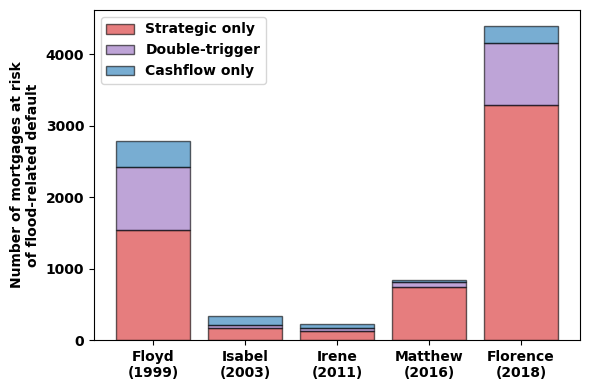

In [54]:
# Stratified by event

columns = ['strategic_only','double_trigger','cashflow_only']
column_labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']

xticklabels = ['Floyd\n(1999)','Isabel\n(2003)','Irene\n(2011)','Matthew\n(2016)','Florence\n(2018)']
xticks = np.arange(len(xticklabels))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))

bottom = np.zeros(len(xticks))

for i in range(0,len(column_labels)):
    height = risk_by_event.loc[:,columns[i]].to_numpy()
    ax.bar(xticks,height,label=column_labels[i],bottom=bottom,color=colors[i],alpha=0.6,ec='k',lw=1)
    bottom += height

    
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Number of mortgages at risk\nof flood-related default')

ax.legend()

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_count_by_event.png')
fig.savefig(outname,dpi=400)

fig.show()

In [66]:
# Stratified by event

columns = ['strategic_only_balance','double_trigger_balance','cashflow_only_balance']
column_labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']

xticklabels = ['Floyd\n(1999)','Isabel\n(2003)','Irene\n(2011)','Matthew\n(2016)','Florence\n(2018)']
xticks = np.arange(len(xticklabels))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))

bottom = np.zeros(len(xticks))

for i in range(0,len(column_labels)):
    height = risk_by_event.loc[:,columns[i]].to_numpy()
    ax.bar(xticks,height,label=column_labels[i],bottom=bottom,color=colors[i],alpha=0.6,ec='k',lw=1)
    bottom += height

for i in range(len(xticks)):
    text = f'${int(np.round(bottom[i]))}M'
    ax.annotate(text,xy=(xticks[i],bottom[i]+5),ha='center',va='bottom')
    
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Unpaid balance on mortgages at risk\nof flood-related default, millions USD')
ax.set_ylim([0,525])

ax.legend()

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_balance_by_event.png')
fig.savefig(outname,dpi=400)

fig.show()

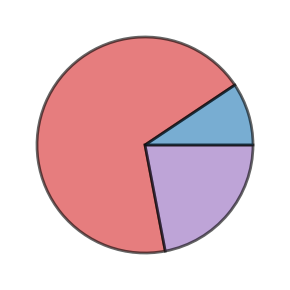

In [126]:
columns = ['strategic_only','double_trigger','cashflow_only']
labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']
wedgeprops={'alpha':0.6,'edgecolor':'k','linewidth':2.0}


x = risk_by_event[columns].sum().to_numpy()
startangle=360*x[2]/np.sum(x)

fig,ax = plt.subplots(figsize=(3,3))

ax.pie(x,colors=colors,startangle=startangle,wedgeprops=wedgeprops)

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_count_pie.png')
fig.savefig(outname,dpi=400)

fig.show()

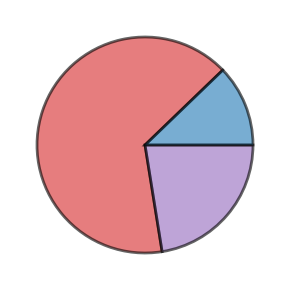

In [127]:
columns = ['strategic_only_balance','double_trigger_balance','cashflow_only_balance']
labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']
wedgeprops={'alpha':0.6,'edgecolor':'k','linewidth':2.0}


x = risk_by_event[columns].sum().to_numpy()
startangle=360*x[2]/np.sum(x)

fig,ax = plt.subplots(figsize=(3,3))

ax.pie(x,colors=colors,startangle=startangle,wedgeprops=wedgeprops)

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_balance_pie.png')
fig.savefig(outname,dpi=400)

fig.show()

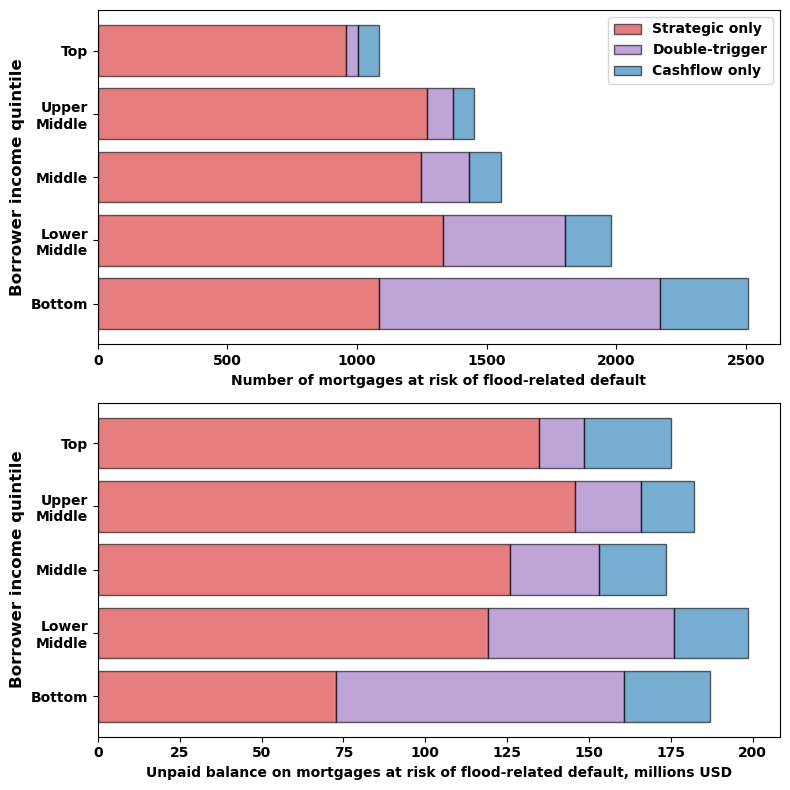

In [110]:
# Stratified by income group

columns = ['strategic_only','double_trigger','cashflow_only']
column_labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']

yticklabels = ['Bottom','Lower\nMiddle','Middle','Upper\nMiddle','Top']
yticks = np.arange(len(yticklabels))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))

ax = axes[0]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_income_group.loc[:,columns[i]].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Number of mortgages at risk of flood-related default')
ax.set_ylabel('Borrower income quintile',fontsize=12)

ax.legend()

ax = axes[1]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_income_group.loc[:,f'{columns[i]}_balance'].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Unpaid balance on mortgages at risk of flood-related default, millions USD')
ax.set_ylabel('Borrower income quintile',fontsize=12)

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_by_income_quintile.png')
fig.savefig(outname,dpi=400)

fig.show()

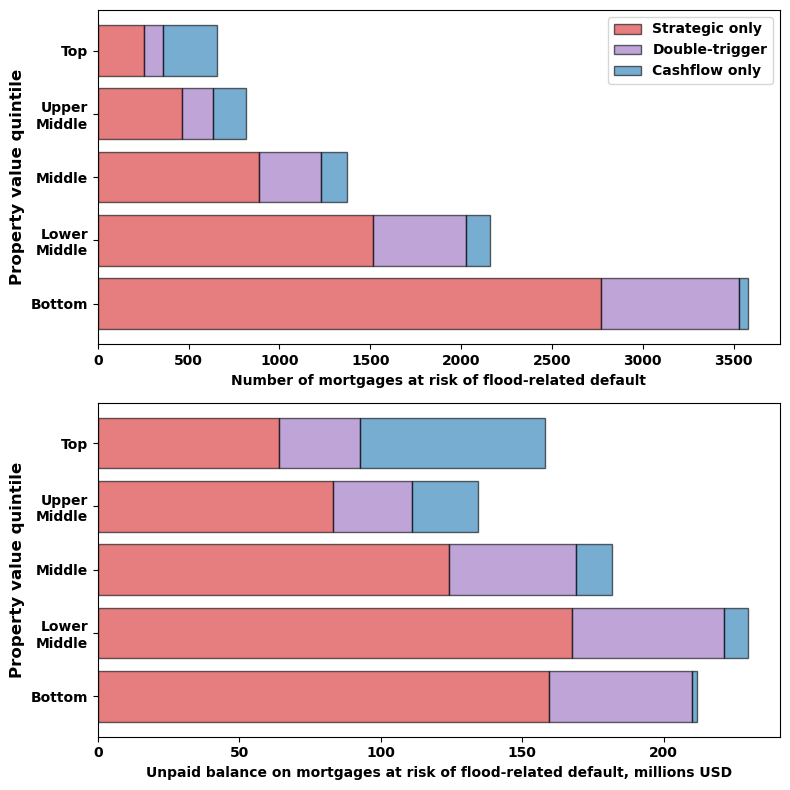

In [70]:
# Stratified by property value group

columns = ['strategic_only','double_trigger','cashflow_only']
column_labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']

yticklabels = ['Bottom','Lower\nMiddle','Middle','Upper\nMiddle','Top']
yticks = np.arange(len(yticklabels))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))

ax = axes[0]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_pv_group.loc[:,columns[i]].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Number of mortgages at risk of flood-related default')
ax.set_ylabel('Property value quintile',fontsize=12)

ax.legend()

ax = axes[1]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_pv_group.loc[:,f'{columns[i]}_balance'].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Unpaid balance on mortgages at risk of flood-related default, millions USD')
ax.set_ylabel('Property value quintile',fontsize=12)

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_by_pv_quintile.png')
fig.savefig(outname,dpi=400)

fig.show()

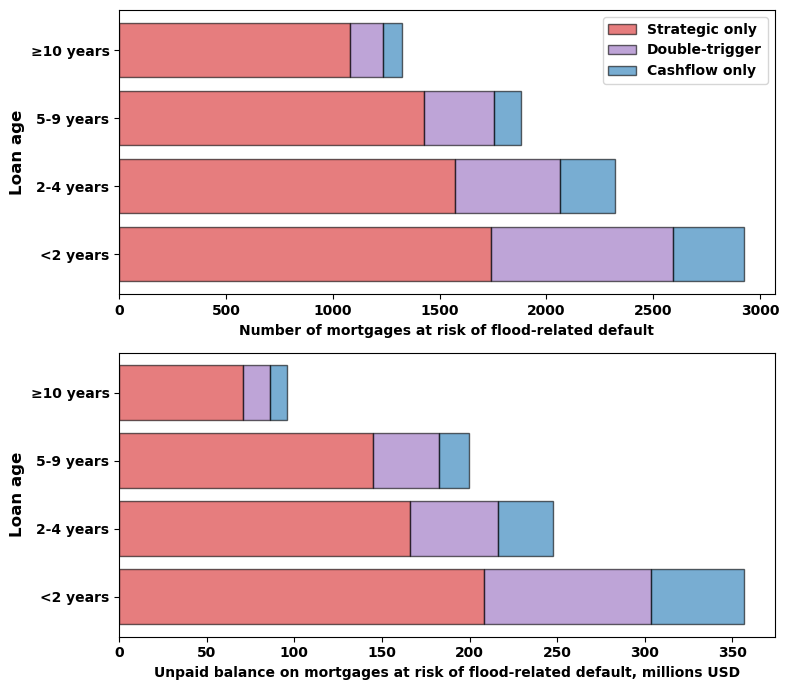

In [84]:
# Stratified by loan age

columns = ['strategic_only','double_trigger','cashflow_only']
column_labels = ['Strategic only','Double-trigger','Cashflow only']
colors = ['C3','C4','C0']

yticklabels = ['<2 years','2-4 years','5-9 years','≥10 years']
yticks = np.arange(len(yticklabels))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(8,7))

ax = axes[0]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_loan_age_group.loc[:,columns[i]].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Number of mortgages at risk of flood-related default')
ax.set_ylabel('Loan age',fontsize=12)

ax.legend()

ax = axes[1]

left = np.zeros(len(yticks))

for i in range(0,len(column_labels)):
    width = risk_by_loan_age_group.loc[:,f'{columns[i]}_balance'].to_numpy()
    ax.barh(yticks,width,label=column_labels[i],left=left,color=colors[i],alpha=0.6,ec='k',lw=1)
    left += width
    
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_xlabel('Unpaid balance on mortgages at risk of flood-related default, millions USD')
ax.set_ylabel('Loan age',fontsize=12)

fig.tight_layout()

outname = os.path.join(outfolder,'default_risk_by_loan_age.png')
fig.savefig(outname,dpi=400)

fig.show()

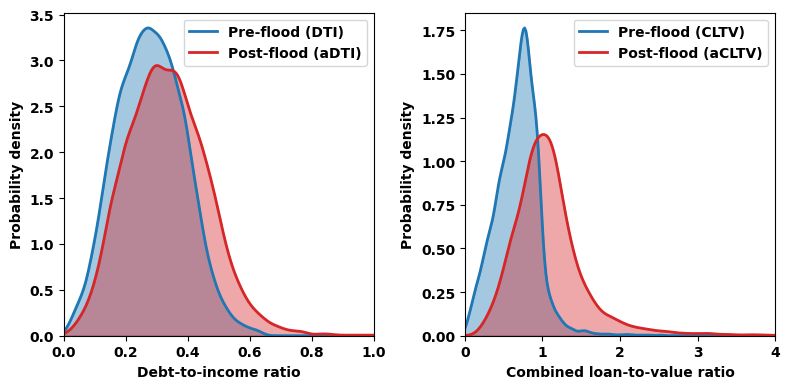

In [134]:
# Look at distributions of LTV & DTI before and after storm

max_DTI = 1.0
max_LTV = 4.0

DTI = uninsured_borrower_df['DTI'].to_numpy()
aDTI = uninsured_borrower_df['aDTI'].to_numpy()

LTV = uninsured_borrower_df['LTV'].to_numpy()
aLTV = uninsured_borrower_df['aLTV'].to_numpy()

DTI_kde = stats.gaussian_kde(DTI)
DTI_pdf = np.vectorize(DTI_kde.pdf)
aDTI_kde = stats.gaussian_kde(aDTI)
aDTI_pdf = np.vectorize(aDTI_kde.pdf)

LTV_kde = stats.gaussian_kde(LTV)
LTV_pdf = np.vectorize(LTV_kde.pdf)
aLTV_kde = stats.gaussian_kde(aLTV)
aLTV_pdf = np.vectorize(aLTV_kde.pdf)

alpha=0.4

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

ax = axes[0]
x = np.linspace(0,max_DTI,250)

ax.plot(x,DTI_pdf(x),color='C0',lw=2,label='Pre-flood (DTI)')
ax.fill_between(x,DTI_pdf(x),color='C0',alpha=alpha)

ax.plot(x,aDTI_pdf(x),color='C3',lw=2,label='Post-flood (aDTI)')
ax.fill_between(x,aDTI_pdf(x),color='C3',alpha=alpha)

ax.set_xlim([0,max_DTI])
ax.set_ylim([0,None])
ax.set_xlabel('Debt-to-income ratio')
ax.set_ylabel('Probability density')

ax.legend()

ax = axes[1]
x = np.linspace(0,max_LTV,250)

ax.plot(x,LTV_pdf(x),color='C0',lw=2,label='Pre-flood (CLTV)')
ax.fill_between(x,LTV_pdf(x),color='C0',alpha=alpha)

ax.plot(x,aLTV_pdf(x),color='C3',lw=2,label='Post-flood (aCLTV)')
ax.fill_between(x,aLTV_pdf(x),color='C3',alpha=alpha)

ax.set_xlim([0,max_LTV])
ax.set_ylim([0,None])
ax.set_xlabel('Combined loan-to-value ratio')
ax.set_ylabel('Probability density')

ax.legend()

fig.tight_layout()

outname = os.path.join(outfolder,'dist_DTI_LTV_pre_post.png')
fig.savefig(outname,dpi=400)

fig.show()

In [173]:
# Look at relative and absolute change in DTI before and after event
uninsured_borrower_df['EQ'] = uninsured_borrower_df['property_value']*(1 - uninsured_borrower_df['LTV'])
uninsured_borrower_df['aEQ'] = uninsured_borrower_df['property_value']*(1 - uninsured_borrower_df['aLTV'])

uninsured_borrower_df['absolute_change_in_DTI'] = uninsured_borrower_df['aDTI'] - uninsured_borrower_df['DTI']
uninsured_borrower_df['absolute_change_in_LTV'] = uninsured_borrower_df['aLTV'] - uninsured_borrower_df['LTV']
uninsured_borrower_df['absolute_change_in_EQ'] = uninsured_borrower_df['aEQ'] - uninsured_borrower_df['EQ']

uninsured_borrower_df['relative_change_in_DTI'] = uninsured_borrower_df['aDTI']/uninsured_borrower_df['DTI'] - 1
uninsured_borrower_df['relative_change_in_LTV'] = uninsured_borrower_df['aLTV']/uninsured_borrower_df['LTV'] - 1
uninsured_borrower_df['relative_change_in_EQ'] = uninsured_borrower_df['aEQ']/uninsured_borrower_df['EQ'] - 1

# Relative change in equity doesn't make sense if you're starting with negative equity, so make these NA
m = uninsured_borrower_df['EQ'] <= 0
uninsured_borrower_df.loc[m,'relative_change_in_EQ'] = np.nan

delta_LTV_DTI_summary = uninsured_borrower_df[['DTI','aDTI','absolute_change_in_DTI','relative_change_in_DTI','LTV','aLTV','absolute_change_in_LTV','relative_change_in_LTV','EQ','aEQ','absolute_change_in_EQ','relative_change_in_EQ']].describe()

outname = os.path.join(outfolder,'delta_LTV_DTI_summary.csv')
delta_LTV_DTI_summary.to_csv(outname)
delta_LTV_DTI_summary

,DTI,aDTI,absolute_change_in_DTI,relative_change_in_DTI,LTV,aLTV,absolute_change_in_LTV,relative_change_in_LTV,EQ,aEQ,absolute_change_in_EQ,relative_change_in_EQ
count,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,13610.000000
mean,0.280977,0.333817,0.052840,0.204700,0.683527,1.091134,0.407607,0.848306,48531.152963,7724.193827,-40806.959136,-3.800964
std,0.108867,0.130837,0.045344,0.182220,0.283273,0.514638,0.389352,4.363223,59991.023819,62794.237491,25661.207664,42.680264
min,0.006658,0.006887,0.000229,0.001695,0.003812,0.098399,0.020272,0.023126,-146202.440176,-352729.562836,-334762.736423,-3112.138159
25%,0.200427,0.239744,0.025116,0.100121,0.506328,0.803634,0.192119,0.285078,13874.206002,-23233.125780,-48960.610430,-2.111229
50%,0.278324,0.327690,0.041076,0.158650,0.704911,1.025202,0.307154,0.448584,33125.138737,-2819.195146,-36000.730753,-0.987553
75%,0.357398,0.419574,0.065485,0.248428,0.847795,1.261678,0.470569,0.824670,65994.640261,28880.057466,-25221.121733,-0.491604
max,0.650000,1.182423,0.697604,3.532531,9.567435,14.387001,6.497050,455.512426,860702.544155,817481.717387,-6169.364825,-0.029378


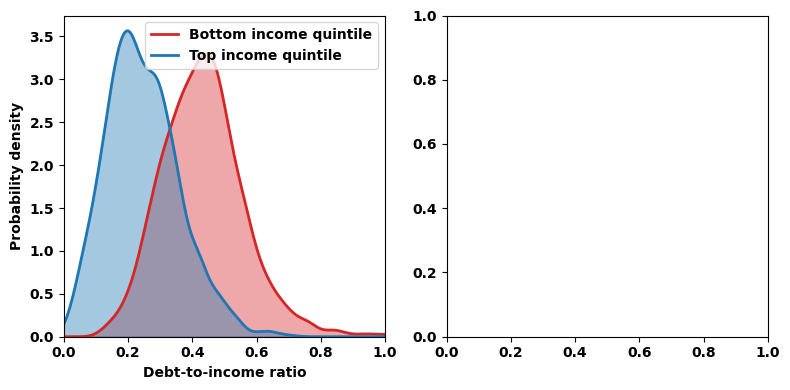

In [175]:
# Look at distributions of LTV & DTI before and after storm

m1 = (uninsured_borrower_df['income_group']==1)
m2 = (uninsured_borrower_df['income_group']==5)

C1 = 'C3'
C2 = 'C0'

label_1 = 'Bottom income quintile'
label_2 = 'Top income quintile'

aDTI_1 = uninsured_borrower_df[m1]['aDTI'].to_numpy()
aDTI_2 = uninsured_borrower_df[m2]['aDTI'].to_numpy()

aLTV_1 = uninsured_borrower_df[m1]['aLTV'].to_numpy()
aLTV_2 = uninsured_borrower_df[m2]['aLTV'].to_numpy()


aDTI_1_kde = stats.gaussian_kde(aDTI_1)
aDTI_1_pdf = np.vectorize(aDTI_1_kde.pdf)
aDTI_2_kde = stats.gaussian_kde(aDTI_2)
aDTI_2_pdf = np.vectorize(aDTI_2_kde.pdf)

aLTV_1_kde = stats.gaussian_kde(aLTV_1)
aLTV_1_pdf = np.vectorize(aLTV_1_kde.pdf)
aLTV_2_kde = stats.gaussian_kde(aLTV_2)
aLTV_2_pdf = np.vectorize(aLTV_2_kde.pdf)

alpha=0.4

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

ax = axes[0]
x = np.linspace(0,max_DTI,250)

ax.plot(x,aDTI_1_pdf(x),color=C1,lw=2,label=label_1)
ax.fill_between(x,aDTI_1_pdf(x),color=C1,alpha=alpha)

ax.plot(x,aDTI_2_pdf(x),color=C2,lw=2,label=label_2)
ax.fill_between(x,aDTI_2_pdf(x),color=C2,alpha=alpha)

ax.set_xlim([0,max_DTI])
ax.set_ylim([0,None])
ax.set_xlabel('Debt-to-income ratio')
ax.set_ylabel('Probability density')

ax.legend()

# ax = axes[1]
# x = np.linspace(0,max_LTV,250)

# ax.plot(x,LTV_pdf(x),color='C0',lw=2,label='Pre-flood (CLTV)')
# ax.fill_between(x,LTV_pdf(x),color='C0',alpha=alpha)

# ax.plot(x,aLTV_pdf(x),color='C3',lw=2,label='Post-flood (aCLTV)')
# ax.fill_between(x,aLTV_pdf(x),color='C3',alpha=alpha)

# ax.set_xlim([0,max_LTV])
# ax.set_ylim([0,None])
# ax.set_xlabel('Combined loan-to-value ratio')
# ax.set_ylabel('Probability density')

# ax.legend()

fig.tight_layout()

#outname = os.path.join(outfolder,'dist_DTI_LTV_by_income.png')
#fig.savefig(outname,dpi=400)

fig.show()